In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [4]:
DATASET_ID = 'buckeye'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'words_full_length_40ms_4ms.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram
0,24.457298,24.722471,uh,[ah],[0.0],[0.2651729999999972],0,0,0,s25,0,o,f,s2501b,16000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 4,..."
1,24.722471,24.900012,it's,"[ih, t, s]","[0.0, 0.06952900000000284, 0.12518900000000244]","[0.06952900000000284, 0.12518900000000244, 0.1...",1,1,1,s25,0,o,f,s2501b,16000,"[[183, 178, 162, 130, 59, 15, 13, 16, 11, 14, ..."
2,24.900012,25.121935,all,"[ao, l]","[0.0, 0.17070899999999867]","[0.17070899999999867, 0.22192300000000031]",4,2,2,s25,0,o,f,s2501b,16000,"[[45, 66, 66, 70, 60, 35, 26, 23, 17, 12, 11, ..."


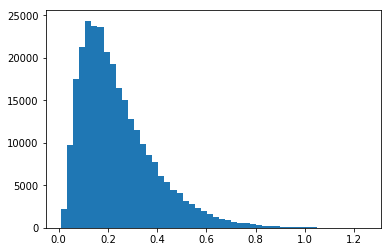

In [9]:
plt.hist(syllable_df.end_time.values - syllable_df.start_time.values, bins=50);

In [10]:
len(syllable_df)

283533

In [11]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,s25,s08,s24,s40,s15,s17,s13,s16,s26,s35,...,s32,s01,s14,s28,s29,s31,s39,s04,s33,s21
0,8445,7738,7425,7006,8273,5228,9177,11664,4446,8774,...,5566,4678,8403,7060,8428,5198,6805,7015,5688,4905


In [12]:
word_phones_df = pd.read_pickle(DATA_DIR/'umap_windows' / DATASET_ID / 'words_phones_freq.pickle')

In [13]:
word_phones_df[:3]

,phones,count
uh,[ah],3580
it's,"[ih, t, s]",2813
all,"[ao, l]",1217


In [76]:
wrds = list(word_phones_df.sort_values(by='count', ascending=False).index[:250])
wrds.sort()
print(wrds)

['I', 'a', 'about', 'actually', 'after', 'all', 'also', 'always', 'an', 'and', 'another', 'any', 'anything', 'are', 'around', 'as', 'at', 'away', 'back', 'bad', 'basically', 'be', 'because', 'been', 'before', 'being', 'believe', 'better', 'big', 'bit', 'but', 'by', 'came', 'can', "can't", 'care', 'children', 'college', 'columbus', 'come', 'could', 'couple', 'day', 'did', "didn't", 'different', 'do', 'does', "doesn't", 'doing', "don't", 'done', 'down', 'else', 'even', 'ever', 'every', 'everybody', 'everything', 'family', 'feel', 'first', 'five', 'for', 'four', 'friends', 'from', 'get', 'getting', 'give', 'go', 'goes', 'going', 'gonna', 'good', 'got', 'guess', 'had', 'hard', 'has', 'have', 'having', 'he', "he's", 'help', 'her', 'here', 'high', 'him', 'his', 'home', 'house', 'how', 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', 'it', "it's", 'job', 'just', 'kid', 'kids', 'kind', 'know', 'let', 'life', 'like', 'little', 'live', 'long', 'look', 'lot', 'make', 'many', 'maybe', 

In [108]:
similarity_plots = [
    #['big', 'bit', 'but'], 
    #### ["then", "they", "them", 'that'], #  "when", "than", 
    ["they", "that"], #  "when", "than", 
    ["them", "then"], #  "when", "than", 
    ['talk', 'take'],
    #["where", "there", "their"],
    ["real", "feel"],
    ['lot', 'let'],
    #['life', 'like', ], # 'light'
    #['mean', 'men'],
    ["five", "i've"], # "live"
    ['same', 'some'],
    ["way", "say", "day"],
    #['but', 'bet', 'bit', 'beat', 'boot', 'bait', 'bought'] # 'bat', 'boat' 'bite'
]

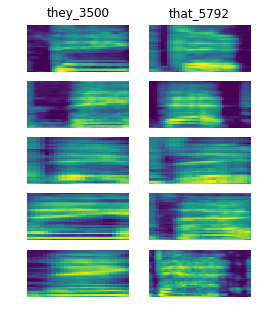

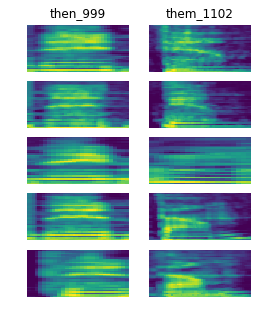

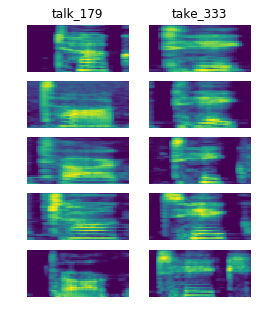

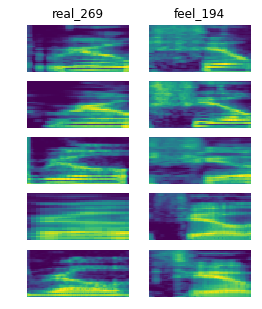

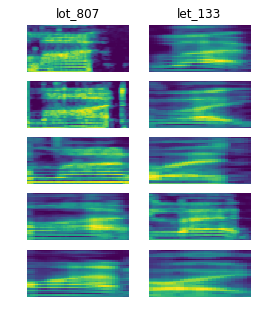

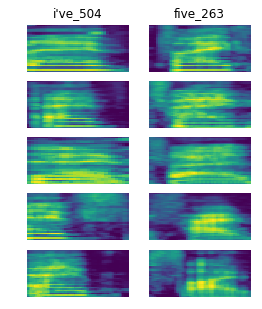

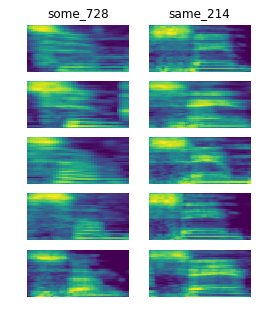

In [100]:
for words in similarity_plots:
    
    # subset syllables of interest
    words_df = syllable_df[syllable_df.word.isin(words)]
    ncols = len(words_df.word.unique())
    nrows = 5
    fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=((ncols)*2, nrows*1))
    for row in range(nrows):
        for wi, word in enumerate(words_df.word.unique()):
            ax = axs[row, wi]
            spec = words_df[words_df.word == word].spectrogram.values[row]
            ax.matshow(spec, aspect='auto', origin='lower')
            if row == 0:
                ax.set_title(word + '_' + str(sum(syllable_df.word == word)))
            ax.axis('off')
    plt.show()

In [101]:
# get spectrograms of words, window each spectrogram, save onsets and offsets of spectrograms as numpy arrays

In [102]:
from itertools import islice

def window(seq, n=2, skip = 100):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [106]:
window_length_ms = 12
hop_length_ms = 4
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

3

In [109]:
for words in similarity_plots:
    
    # skip if already created
    save_loc = (
        DATA_DIR
        / "umap_windows"
        / DATASET_ID
        / ("_".join(words) + "_" + str(window_length_ms) + '.pickle')
    )
    print(save_loc)
    if save_loc.exists():
        continue
    
    # subset syllables of interest
    words_df = syllable_df[syllable_df.word.isin(words)]
    # get spectrograms for words
    windows = [np.array([i for i in window(row.spectrogram.T, n=window_length_frames)]) for idx, row in tqdm(words_df.iterrows(), total=len(words_df))]
    words_df['windows'] = windows
    
    # save windows to dataframe
    ensure_dir(DATA_DIR / "umap_windows" / DATASET_ID)
    words_df.to_pickle(save_loc)


/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/they_that_12.pickle
/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/them_then_12.pickle
/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/talk_take_12.pickle
/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/real_feel_12.pickle
/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/lot_let_12.pickle
/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/five_i've_12.pickle
/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/same_some_12.pickle
/local/home/tsainbur/github_repos/avgn_paper/data/umap_windows/buckeye/way_say_day_12.pickle


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
words_df[:3]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram,windows
445,236.236188,236.352105,say,"[s, eh]","[0.0, 0.060875000000010004]","[0.060875000000010004, 0.11591699999999605]",74,31,31,s25,0,o,f,s2501b,16000,"[[23, 20, 13, 10, 8, 10, 11, 14, 17, 29, 36, 4...","[[[23, 33, 18, 28, 2, 17, 1, 0, 7, 9, 7, 3, 4,..."
492,250.321120,250.586825,say,"[s, ey]","[0.0, 0.1448169999999891]","[0.1448169999999891, 0.26570499999999697]",17,10,10,s25,0,o,f,s2501b,16000,"[[10, 9, 6, 2, 0, 1, 3, 4, 3, 1, 0, 0, 0, 0, 3...","[[[10, 2, 26, 62, 29, 6, 9, 0, 0, 0, 0, 0, 4, ..."
610,293.978018,294.234862,say,"[s, ey]","[0.0, 0.13373199999995222]","[0.13373199999995222, 0.25684400000000096]",22,9,9,s25,0,o,f,s2501b,16000,"[[174, 170, 157, 133, 95, 53, 30, 23, 20, 17, ...","[[[174, 118, 112, 135, 116, 80, 47, 74, 76, 83..."


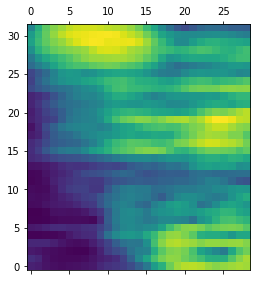

In [36]:
plt.matshow(words_df.iloc[0].spectrogram, origin='lower')

IndexError: index 28 is out of bounds for axis 0 with size 28

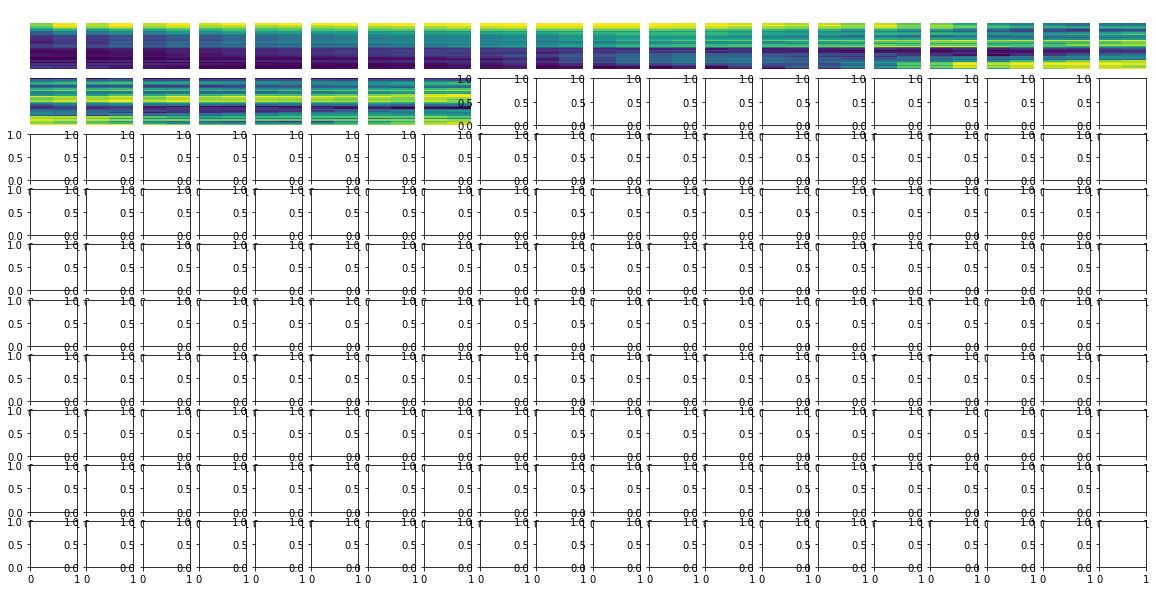

In [37]:
ncols = 10
nrows = 5
zm = 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(zm*ncols, zm*nrows))
for axi in tqdm(range(ncols*nrows)):
    ax = axs.flatten()[axi]
    ax.matshow(windows[0][axi].T, aspect='auto', origin='lower')
    ax.axis('off')

In [92]:
words_df[:5]

,start_time,end_time,word,phones,phone_start_times,phone_end_times,utterance_number,position_in_utterance,word_number,indv,indvi,age,sex,key,rate,spectrogram,windows
4,25.588546,25.778605,they,"[dh, ey]","[0.0, 0.06714699999999851]","[0.06714699999999851, 0.19005899999999798]",10,4,4,s25,0,o,f,s2501b,16000,"[[3, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[3, 23, 38, 44, 47, 47, 44, 36, 20, 8, 0, 1,..."
26,33.108949,33.305837,they,"[dh, ey]","[0.0, 0.08692599999999828]","[0.08692599999999828, 0.19688799999999418]",11,6,6,s25,0,o,f,s2501b,16000,"[[48, 83, 111, 130, 143, 152, 158, 162, 165, 1...","[[[48, 111, 142, 139, 134, 135, 136, 124, 81, ..."
69,48.811535,48.956812,then,"[n, eh, n]","[0.0, 0.018174999999999386, 0.11372099999999818]","[0.018174999999999386, 0.11372099999999818, 0....",2,1,1,s25,0,o,f,s2501b,16000,"[[205, 205, 203, 202, 200, 198, 196, 194, 193,...","[[[205, 199, 141, 98, 153, 150, 127, 113, 117,..."
84,54.420270,54.759360,them,"[dh, eh, m]","[0.0, 0.06698699999999747, 0.23886999999999858]","[0.06698699999999747, 0.23886999999999858, 0.3...",18,5,5,s25,0,o,f,s2501b,16000,"[[31, 30, 29, 26, 22, 18, 14, 11, 9, 7, 5, 5, ...","[[[31, 15, 1, 0, 0, 10, 29, 34, 28, 8, 0, 0, 0..."
94,56.720679,56.811552,they,"[dh, ey]","[0.0, 0.02804100000000176]","[0.02804100000000176, 0.09087300000000198]",48,16,16,s25,0,o,f,s2501b,16000,"[[149, 150, 150, 152, 154, 156, 157, 157, 157,...","[[[149, 133, 111, 128, 161, 180, 185, 177, 164..."
